In [22]:
from os import listdir
from os.path import isdir, join
from tensorflow.keras import layers, models
import numpy as np

In [23]:
# Create list of all targets (minus background noise)
dataset_path = '/tf/voicereg/datasets'
all_targets = all_targets = [name for name in listdir(dataset_path) if isdir(join(dataset_path, name))]
# all_targets.remove('.ipynb_checkpoints')
print(all_targets)

['trai', 'phai', 'dunglai', 'len', 'xuong', 'co', 'dongy', 'khong']


In [24]:
# Settings
feature_sets_path = '/tf/voicereg'
feature_sets_filename = 'all_targets_mfcc_sets.npz'
model_filename = 'model_softmax.h5'
# wake_word = 'stop'

In [25]:
# Load feature sets
feature_sets = np.load(join(feature_sets_path, feature_sets_filename))
print(feature_sets.files)

['x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test']


In [26]:
# Assign feature sets
x_train = feature_sets['x_train']
y_train = feature_sets['y_train']
x_val = feature_sets['x_val']
y_val = feature_sets['y_val']
x_test = feature_sets['x_test']
y_test = feature_sets['y_test']

In [27]:
# Look at tensor dimensions
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(529, 16, 16)
(66, 16, 16)
(66, 16, 16)


In [28]:
# Peek at labels
print(y_val)

[3. 7. 3. 2. 3. 3. 7. 7. 1. 7. 7. 5. 7. 3. 5. 6. 3. 1. 6. 7. 4. 3. 1. 7.
 7. 0. 0. 4. 2. 4. 0. 0. 1. 1. 1. 4. 4. 3. 1. 2. 2. 4. 5. 0. 7. 3. 4. 3.
 0. 3. 1. 0. 3. 1. 1. 4. 0. 4. 4. 6. 7. 4. 3. 3. 2. 1.]


In [29]:
# Convert ground truth arrays to one wake word (1) and 'other' (0)
# wake_word_index = all_targets
# y_train = np.equal(y_train, wake_word_index).astype('float64')
# y_val = np.equal(y_val, wake_word_index).astype('float64')
# y_test = np.equal(y_test, wake_word_index).astype('float64')

In [30]:
# Peek at labels after conversion
print(y_val)

[3. 7. 3. 2. 3. 3. 7. 7. 1. 7. 7. 5. 7. 3. 5. 6. 3. 1. 6. 7. 4. 3. 1. 7.
 7. 0. 0. 4. 2. 4. 0. 0. 1. 1. 1. 4. 4. 3. 1. 2. 2. 4. 5. 0. 7. 3. 4. 3.
 0. 3. 1. 0. 3. 1. 1. 4. 0. 4. 4. 6. 7. 4. 3. 3. 2. 1.]


In [31]:
# What percentage of 'stop' appear in validation labels
print(sum(y_val) / len(y_val))
print(1 - sum(y_val) / len(y_val))

3.287878787878788
-2.287878787878788


In [32]:
# View the dimensions of our input data
print(x_train.shape)

(529, 16, 16)


In [33]:
# CNN for TF expects (batch, height, width, channels)
# So we reshape the input tensors with a "color" channel of 1
x_train = x_train.reshape(x_train.shape[0], 
                          x_train.shape[1], 
                          x_train.shape[2], 
                          1)
x_val = x_val.reshape(x_val.shape[0], 
                      x_val.shape[1], 
                      x_val.shape[2], 
                      1)
x_test = x_test.reshape(x_test.shape[0], 
                        x_test.shape[1], 
                        x_test.shape[2], 
                        1)
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(529, 16, 16, 1)
(66, 16, 16, 1)
(66, 16, 16, 1)


In [34]:
# Input shape for CNN is size of MFCC of 1 sample
sample_shape = x_test.shape[1:]
print(sample_shape)

(16, 16, 1)


In [35]:
# Build model
# Based on: https://www.geeksforgeeks.org/python-image-classification-using-keras/
model = models.Sequential()
model.add(layers.Conv2D(32, 
                        (2, 2), 
                        activation='relu',
                        input_shape=sample_shape))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, (2, 2), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Classifier
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(8, activation='softmax'))

In [36]:
# Display model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 15, 15, 32)        160       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 6, 6, 32)          4128      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 3, 3, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 64)          8256      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 1, 64)        

In [37]:
# Add training parameters to model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer='adam', 
              metrics=['acc'])

In [38]:
# Train
history = model.fit(x_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=100, 
                    validation_data=(x_val, y_val))

Epoch 1/30
6/6 [==============================] - 2s 115ms/step - loss: 2.9369 - acc: 0.1172 - val_loss: 1.9463 - val_acc: 0.2273
Epoch 2/30
6/6 [==============================] - 0s 53ms/step - loss: 2.1517 - acc: 0.1342 - val_loss: 1.8848 - val_acc: 0.2273
Epoch 3/30
6/6 [==============================] - 0s 51ms/step - loss: 2.0193 - acc: 0.1909 - val_loss: 1.9019 - val_acc: 0.3030
Epoch 4/30
6/6 [==============================] - 0s 51ms/step - loss: 1.9522 - acc: 0.2382 - val_loss: 1.8594 - val_acc: 0.4545
Epoch 5/30
6/6 [==============================] - 0s 53ms/step - loss: 1.9232 - acc: 0.2665 - val_loss: 1.8229 - val_acc: 0.5000
Epoch 6/30
6/6 [==============================] - 0s 50ms/step - loss: 1.8432 - acc: 0.3006 - val_loss: 1.7413 - val_acc: 0.5152
Epoch 7/30
6/6 [==============================] - 0s 60ms/step - loss: 1.7627 - acc: 0.3611 - val_loss: 1.6272 - val_acc: 0.5909
Epoch 8/30
6/6 [==============================] - 0s 75ms/step - loss: 1.6975 - acc: 0.4234 - va

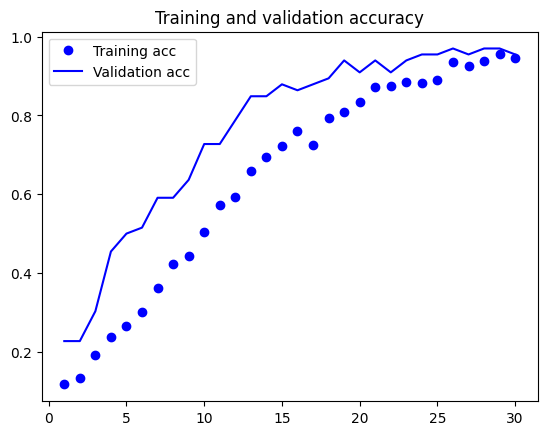

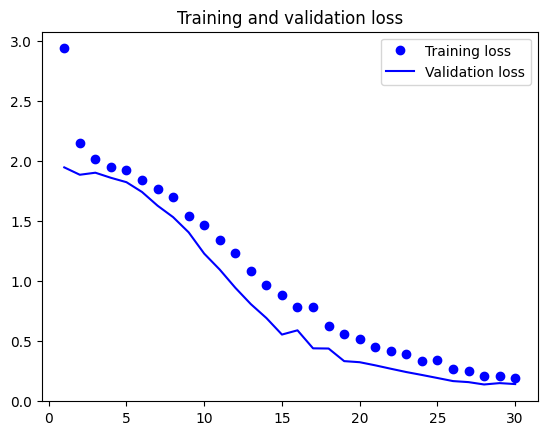

In [39]:
# Plot results
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [40]:
# Save the model as a file
models.save_model(model, model_filename)

In [41]:
# See which are 'stop'
for idx, y in enumerate(y_test):
    if y == 1:
        print(idx)

0
15
17
20
24
37
45
52
56
65


In [42]:
# TEST: Load model and run it against test set
model = models.load_model(model_filename)
for i in range(0, 10):
    print('Answer:', y_test[i], ' Prediction:', model.predict(np.expand_dims(x_test[i], 0)))

1/1 [==============================] - 0s 275ms/step
Answer: 1.0  Prediction: [[2.4537548e-02 9.7424537e-01 3.4820326e-04 3.8046352e-04 2.5166775e-04
  6.6627596e-05 1.3961064e-04 3.0498841e-05]]
1/1 [==============================] - 0s 49ms/step
Answer: 0.0  Prediction: [[9.9879682e-01 1.0982265e-03 2.0926623e-06 8.4807856e-05 3.6335673e-06
  9.0534722e-06 4.6021478e-06 7.1180580e-07]]
1/1 [==============================] - 0s 52ms/step
Answer: 5.0  Prediction: [[8.7103475e-04 1.1744344e-02 3.3691360e-04 4.5113137e-04 3.5796914e-04
  9.8035675e-01 2.1459630e-03 3.7358399e-03]]
1/1 [==============================] - 0s 51ms/step
Answer: 5.0  Prediction: [[0.02295732 0.08031273 0.00079748 0.00173777 0.00279339 0.67689365
  0.00184559 0.21266209]]
1/1 [==============================] - 0s 52ms/step
Answer: 0.0  Prediction: [[9.9672168e-01 2.3415901e-03 3.7100799e-05 1.7424046e-04 1.5594345e-04
  4.6506966e-04 2.5192898e-05 7.9295693e-05]]
1/1 [==============================] - 0s 65ms/s

In [43]:
# Evaluate model with test set
model.evaluate(x=x_test, y=y_test)

3/3 [==============================] - 0s 9ms/step - loss: 0.1399 - acc: 0.9697


[0.1398923397064209, 0.9696969985961914]

In [40]:
print(y_test)

[7. 8. 4. ... 1. 2. 1.]
